### Fine-scale diversity due to satellite niches in ecosystems with boom-and-bust cycles

It has long been known that more than one strains with similar functions can coexist in both natural and lab environments, yet the mechanism behind remains as a puzzle. Here, we propose a model to study this coexitence, where strains that obey Monod's growth law undergo boom and bust cycles. 

Here, we take strain pools of different species (defined by having a distinct function, i.e. portion of protein it use to consume different resources) and investigate the survivors from such pools. We see that there can be multiple strains from the same species coexisting in the final state. We say these strains are in satellite niches of their species. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import copy
import pickle
from math import *
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

%matplotlib inline

In [2]:
# g: maximum growth rate
# K: Monod constant
def OneStep(t, u, p, x):# Just set R=1 and Y=[1, ..1] for simplicity
    N, gmax, K, switch_thres = p
    Ni, Rj = u[:N], u[N:]
    gs = gmax*Rj**x/(Rj**x+K**x)*(Rj>0)
    return np.hstack([Ni*gs, -sum(Ni*gs)])


def Dilute(p, p_dilute, u_end, x=1):
    N, gmax, K, switch_thres = p
    c0, d, t, n, fluc_thres, elim_thres = p_dilute
    # add c0 amount of resource at beginning of cycle
    # dilution factor d
    # boom and bust cycle period t
    # dilute for at most n cycles
    output = u_end
    u_add = np.zeros(N+1)
    u_add[-1] = c0
    stop, count = 1, 1
    utransf = copy.deepcopy(u_end)
    while stop>0 and count<n: 
        u = copy.deepcopy(utransf)
        u = u/d + u_add
        sol = solve_ivp(OneStep, t_span=[0, t], y0=u, method="LSODA", args=[p, x], rtol=1e-5)
        utransf = sol.y[:, -1] * (sol.y[:, -1]>elim_thres*d)
        output = np.vstack([output, utransf])
        stop = sum(abs((output[-1, :-1]-output[-2, :-1])) > fluc_thres*output[-1, :-1])
        count+=1
    return output

In [3]:
# Check if 2 species can coexist for 1000 days
def checkCoex(g, K, c0, D, colors = ['m', 'r']):
    g1, g2 = g
    K1, K2 = K
    A = c0*D/(D-1)
    ginvLower = g1*(A+K2)*log(D)/((A+K1)*log(D)+(K1-K2)*np.log((c0+K2)/(K2)))
    ginvHigher = g1*((A+K2)*log(D)-(K1-K2)*np.log((c0+K1)/K1))/((A+K1)*log(D))
    
    gs_all, Ks_all = np.array(g), np.array(K)
    x = 1 
    p = len(gs_all), gs_all, Ks_all, 0
    t, n, fluc_thres, elim_thres = 24.0, 1000, 1e-5, 2.0e-7
    
    p_dilute = c0, D, t, n, fluc_thres, elim_thres
    u_end = np.array([1.0 for i in gs_all]+[0.0])
    profile = Dilute(p, p_dilute, u_end, x)
    for i in range(profile.shape[1]-1):
        plt.plot(range(profile.shape[0]), profile[0:, i]/D, color = colors[i])
    plt.xlabel("Dilution cycles")
    plt.ylabel("Abundance")
    plt.axhline(0, color = 'k', alpha=0.4)
    print(profile[-1,:])
    plt.show()

    return ginvLower, ginvHigher, ginvLower<g2<ginvHigher

def findPareto(gs_all, Ks_all):
    bugs = [[gs_all[i], Ks_all[i]] for i in range(len(gs_all))]
    paretobugs = [bugs[0]]
    for bug_out in bugs:
        add = 1
        removed = []
        for bug_in in paretobugs:
            if(bug_out[0]>bug_in[0] and bug_out[1]<bug_in[1]):
                removed.append(bug_in)
            elif(bug_out[0]<=bug_in[0] and bug_out[1]>=bug_in[1]):
                add=0
                break
        for bugremoved in removed:
            paretobugs.remove(bugremoved)
        if(add==1):
            paretobugs.append(bug_out)
    paretobugs.sort(key=lambda x:x[0])
    return paretobugs

# for strain B0 with known K0 and g0, and strain B1 with known K1, 
# find the range of g1 that B0 and B1 can coexist under the environment of (c0, D).
def getgBounds(g0, K0, K1, c0, D):
    A = c0*D/(D-1)
    ginvLower = g0*(A+K1)*log(D)/((A+K0)*log(D)+(K0-K1)*np.log((c0+K1)/(K1)))
    ginvHigher = g0*((A+K1)*log(D)-(K0-K1)*np.log((c0+K0)/K0))/((A+K0)*log(D))
    return ginvLower, ginvHigher

# for a list of strains, find the set among them where the rest cannot invade
# but it is not guaranteed that they can form a stable coexistence. 
def findCoexistPareto(paretobugs, c0, D):
    if(len(paretobugs)==1):
        return paretobugs
    first=0
    while(first<len(paretobugs)):
        last=first+1
        while last<=len(paretobugs)-1:
            g0, K0 = paretobugs[first]
            g1, K1 = paretobugs[last]
            if(g1<getgBounds(g0, K0, K1, c0, D)[0]):
                paretobugs.remove(paretobugs[last])
            elif(g1>getgBounds(g0, K0, K1, c0, D)[1]):
                paretobugs.remove(paretobugs[first])
            else:
                last += 1
        first += 1
    return paretobugs

### We start from a single resource and single species

There could be 2 or even 3 satellite niches for a single species. 

In [10]:
# randomly generate 2000 pools, each one has 100 strains
N=100
Nsamples = 2000
all_paretobugs = []
thres=1e-2
all_params = []
c0, D, t, n, fluc_thres, elim_thres = 10.0, 10.0, 24.0, 10000, 1e-5, 2.0e-7
for i in range(Nsamples):
    gs_all = np.exp(np.random.normal(log(1), 0.05, size=N))
    gs_all *= (gs_all>0)
    Ks_all = 10**np.random.normal(log10(4), 0.5, size=N)
    x = 1
    paretobugs = findCoexistPareto(findPareto(gs_all, Ks_all), c0, D)
    all_paretobugs.append(paretobugs)
    all_params.append([gs_all, Ks_all])
    
print("number of coexistence community", len([i for i in all_paretobugs if len(i)>2]))
    
for idx, i in enumerate(all_paretobugs):
    if(len(i)>2):
        print("coexistence community", i)
        paretobugs = i
        gs_pareto = np.array([i[0] for i in paretobugs])
        Ks_pareto = np.array([i[1] for i in paretobugs])
        p = len(gs_pareto), gs_pareto, Ks_pareto, 0
        p_dilute = c0, D, t, n, fluc_thres, elim_thres
        u_end = np.array([1.0 for i in gs_pareto]+[0.0])
        profile = Dilute(p, p_dilute, u_end, x)
        all_paretobugs[idx] = [j for jdx, j in enumerate(i) if profile[-1][jdx]>0]
        print("index of that community", idx)
        print("final profile", profile[-1])

number of coexistence community 2
coexistence community [[1.0129039322408333, 0.16894171079681455], [1.0921105875522974, 0.48642814731585643], [1.1799589005680498, 0.9124767440293353]]
index of that community 695
final profile [3.62131667 0.01137843 7.47841602 0.        ]
coexistence community [[0.9674590707974304, 0.45056709952411456], [1.0151638305652246, 0.693363919124809], [1.158425502180989, 1.4575872437223094]]
index of that community 1319
final profile [ 2.48084328  0.          8.63026764 -0.        ]


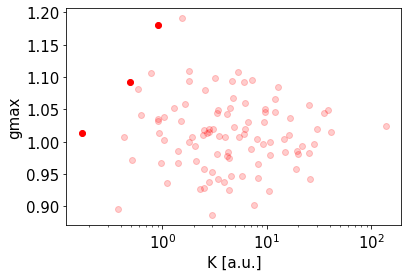

In [13]:
index = 695

gs_all, Ks_all = all_params[index]
plt.scatter(Ks_all, gs_all, color='r', alpha=0.2)
gs_pareto, Ks_pareto = [i[0] for i in all_paretobugs[index]], [i[1] for i in all_paretobugs[index]]
plt.scatter(Ks_pareto, gs_pareto, color='r')
plt.xscale("log")
plt.xlabel("K [a.u.]", fontsize=15)
plt.ylabel("$g_{max}$ [hr$^{-1}$]",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("gmax")
plt.show()

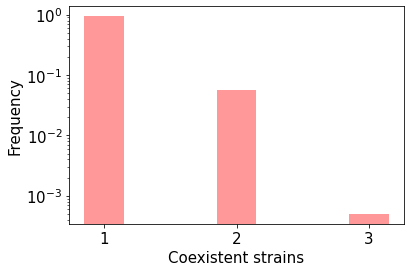

In [12]:
labels = np.array([1, 2, 3])
coex = [len(i) for i in all_paretobugs]
plt.bar(labels, [coex.count(i)/len(coex) for i in labels], color='r', alpha=0.4, width=0.3)
plt.xticks(labels, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Coexistent strains", fontsize=15)
plt.yscale("log")
plt.ylabel("Frequency", fontsize=15)
plt.show()

### Now run the simulation for 2 resource and 2 species. 

In [ ]:
# species A: xA = 0.2(consumes 0.2 resource 1 and 0.8 resource 2)
# species B: xB = 0.7(consumes 0.7 resource 1 and 0.3 resource 2)
# species A has g mutating around 1 and K around 4
# species B has g mutationg around 0.55 and K around 0.01

all_survivors = []
all_params = []

for pool in range(500):

    gA1, gA2, KA1, KA2 = 1, 1, 4, 5
    gB1, gB2, KB1, KB2 = 0.55, 0.55, 0.05, 0.03

    N_pool = 50
    # plt.scatter(KA1, gA1, color = 'b')
    # plt.scatter(KA2, gA2, color = 'c')
    # plt.scatter(KB1, gB1, color = 'r')
    # plt.scatter(KB2, gB2, color = 'm')
    plt.xscale("log")

    g_diff = np.random.normal(0, 0.05, size = 2*N_pool)
    K_exp = np.random.normal(0, 0.3, size = 4*N_pool)
    gA1new = [gA1+i for i in g_diff[0:N_pool]]
    gA2new = [gA2+i for i in g_diff[0:N_pool]]
    gB1new = [gB1+i for i in g_diff[N_pool:2*N_pool]]
    gB2new = [gB2+i for i in g_diff[N_pool:2*N_pool]]
    KA1new = [KA1*(10**i) for i in K_exp[0:N_pool]]
    KA2new = [KA2*(10**i) for i in K_exp[N_pool:2*N_pool]]
    KB1new = [KB1*(10**i) for i in K_exp[2*N_pool:3*N_pool]]
    KB2new = [KB2*(10**i) for i in K_exp[3*N_pool:4*N_pool]]
    plt.scatter(KA1new, gA1new, color = 'b', alpha = 0.2)
    plt.scatter(KA2new, gA2new, color = 'b', alpha = 0.2)
    plt.scatter(KB1new, gB1new, color = 'r', alpha = 0.2)
    plt.scatter(KB2new, gB2new, color = 'r', alpha = 0.2)

    N, R = 2*N_pool, 2
    gmax = np.array([[gA1new[i], gA2new[i]] for i in range(N_pool)]+[[gB1new[i], gB2new[i]] for i in range(N_pool)])
    K = np.array([[KA1new[i], KA2new[i]] for i in range(N_pool)]+[[KB1new[i], KB2new[i]] for i in range(N_pool)])
    x = np.array([[0.2 for i in range(N_pool)]+[0.7 for i in range(N_pool)]])
    c0, D, t, n, fluc_thres, elim_thres = [10, 10], 10, 24.0, 5000, 1e-5, 1.0e-6
    p = N, R, gmax, K, x
    p_dilute = c0, D, t, n, fluc_thres, elim_thres
    u_end = np.array([1 for i in range(2*N_pool)] + [0, 0])
    plt.xscale("log")
    start=time.time()
    profile = Dilute(p, p_dilute, u_end)
    end=time.time()
    print(end-start)
    survivors = [idx for idx, i in enumerate(profile[-1, :-2]) if i > 0]
    print(len(survivors))
    for i in survivors:
        if(i<N_pool):
            plt.scatter(KA1new[i], gA1new[i], color = 'b')
            plt.scatter(KA2new[i], gA1new[i], color = 'b')
        else:
            plt.scatter(KB1new[i-N_pool], gB1new[i-N_pool], color = 'r')
            plt.scatter(KB2new[i-N_pool], gB1new[i-N_pool], color = 'r')
    plt.show()
    
    all_survivors.append(survivors)
    all_params.append([gA1new, gB1new, KA1new, KA2new, KB1new, KB2new])
    pickle.dump((all_survivors, all_params),open("data/2_res_new_results_K_separated.pkl", "wb"))

In [3]:
file = open("data/2_res_new_results_K_separated.pkl",'rb')
all_survivors,all_params = pickle.load(file)

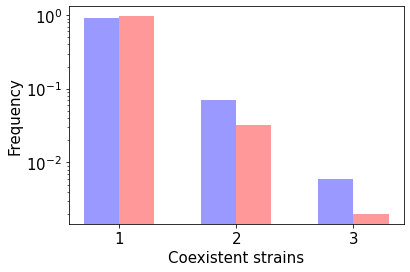

In [4]:
strain_cat = [[j>49 for j in i] for i in all_survivors]
a_s = [i.count(1) for i in strain_cat]
b_s = [i.count(0) for i in strain_cat]
b_s[10]=3

labels = np.array([1, 2, 3])
plt.bar(labels-0.3/2, [a_s.count(i)/len(all_params) for i in labels], color='b', alpha=0.4, width=0.3)
plt.bar(labels+0.3/2, [b_s.count(i)/len(all_params) for i in labels], color='r', alpha=0.4, width=0.3)
plt.xticks(labels, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Coexistent strains", fontsize=15)
plt.yscale("log")
plt.ylabel("Frequency", fontsize=15)
plt.show()

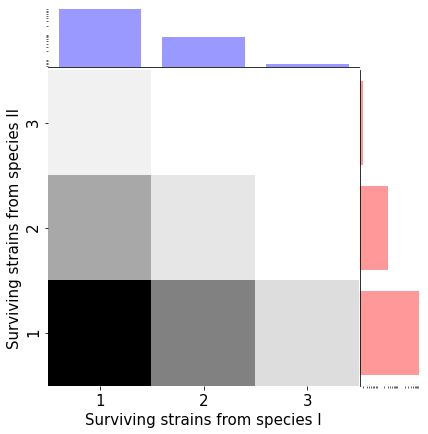

In [5]:
heatmap = np.zeros([3, 3])
for i in range(len(strain_cat)):
    heatmap[3-b_s[i], a_s[i]-1] += 1
    

import pandas as pd
xrange = 3
yrange = 3
Isurvivor = np.repeat(range(1, xrange+1), yrange)
IIsurvivor = np.tile(range(1, yrange+1), xrange)
df = pd.DataFrame({"I survivor": Isurvivor,
                  "II survivor": IIsurvivor,
                  "percentage": np.array([heatmap[Isurvivor[i]-1, IIsurvivor[i]-1] for i in range(9)]) })

g = sns.jointplot(data=df, x='I survivor', y='II survivor', kind='hist', bins=(xrange, yrange))
g.ax_marg_y.cla()
g.ax_marg_x.cla()
sns.heatmap(data=np.log(df['percentage'].to_numpy().reshape(xrange, yrange)+1), ax=g.ax_joint, cbar=False, cmap='Greys')
# g.ax_joint.hlines(y=np.arange(0, 3), xmin=np.full(3, 0), xmax=np.full(3, 3), color="black")
# g.ax_joint.vlines(x=np.arange(0, 3), ymin=np.full(3, 0), ymax=np.full(3, 3), color="black")

g.ax_marg_y.barh(np.arange(0.5, yrange), df.groupby(['I survivor'])['percentage'].sum().to_numpy()/len(strain_cat), color='r', alpha = 0.4)
g.ax_marg_x.bar(np.arange(0.5, xrange), df.groupby(['II survivor'])['percentage'].sum().to_numpy()/len(strain_cat), color='b', alpha = 0.4)

g.ax_joint.set_xticks(np.arange(0.5, xrange))
g.ax_joint.set_xticklabels([1, 2, 3], fontsize=15)
g.ax_joint.set_yticks(np.arange(0.5, yrange))
g.ax_joint.set_yticklabels([3, 2, 1], fontsize=15)
g.ax_joint.set_xlabel("Surviving strains from species I", fontsize=15)
g.ax_joint.set_ylabel("Surviving strains from species II", fontsize=15)

g.ax_marg_x.set_yscale("log")
g.ax_marg_y.set_xscale("log")
g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
# plt.savefig("heatmap.pdf")